In [1]:
import requests
import numpy as np
import pandas as pd
import re
import os

from dataclasses import dataclass, field
from typing import Optional, List
from datetime import datetime, timedelta, timezone

import matplotlib as mpl
import matplotlib.pyplot as plt

from cycler import cycler

# Plot Configuration

In [2]:
# mpl.use("pdf")
# plt.close("all")
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "pgf.texsystem": "pdflatex",
        "font.size": 12,  # footnote/caption size 9pt for paper
        # "font.size": 10,     # caption size 10pt on thesis
        "pgf.preamble": "\n".join(
            [
                r"\usepackage{libertine}",
                # r"\usepackage{lmodern}",
            ]
        ),
        # "lines.linewidth": 0.8,
        "lines.markersize": 3,
        "axes.linewidth": 0.5,
        "grid.linewidth": 0.3,
        "grid.linestyle": "-",
        "axes.edgecolor": mpl.rcParams["grid.color"],
        # "ytick.color": mpl.rcParams["grid.color"],
        "ytick.direction": "in",
        # "xtick.color": mpl.rcParams["grid.color"],
        "xtick.direction": "in",
        "axes.titlesize": "medium",
        "axes.titlepad": 4,
        "axes.labelpad": 1,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.spines.bottom": False,
        "axes.spines.left": False,
        "axes.axisbelow": True,  # grid below patches
        "axes.prop_cycle": cycler(
            "color", ["#348ABD", "#7A68A6", "#A60628", "#467821", "#CF4457", "#188487", "#E24A33"]
        ),
        "legend.labelspacing": 0.1,
        "legend.handlelength": 1,
        "legend.handletextpad": 0.2,
        "legend.columnspacing": 1,
        "legend.borderpad": 0.1,
    }
)


In [3]:
@dataclass
class AxisConfig:
    labels: list[str] = field(default_factory=list)
    ylabel: str = None
    ylim: tuple[float, float] = None
    plot_kwargs: list[dict] = field(default_factory=list)  # List of dicts for each series' styling


@dataclass
class CommonPlotConfig:
    title: str
    xlim: tuple[float, float] = None
    figsize: tuple[int, int] = (10, 6)
    show_legend: bool = True
    legend_kwargs: dict = field(default_factory=dict)
    tight_layout: bool = True
    grid: bool = True
    grid_minor: bool = True
    grid_kwargs: dict = field(default_factory=dict)
    minor_grid_kwargs: dict = field(default_factory=dict)
    minor_ticks: bool = True
    subplots_adjust: dict = None
    time_unit: str = 's'

@dataclass
class PlotConfig:
    common: CommonPlotConfig
    primary_axis: AxisConfig
    secondary_axis: AxisConfig = None

In [4]:
#NOT USED

# PROMETHEUS_URL = "http://localhost:40333/api/v1"

# @dataclass
# class PrometheusQueryConfig:
#     prometheus_url: str
#     query: str
#     start: float
#     end: float
#     step: str = '1s'

# def list_all_metrics(prometheus_url):
#     response = requests.get(f"{prometheus_url}/label/__name__/values")
#     if response.status_code == 200:
#         return response.json()['data']
#     else:
#         raise Exception(f"Error fetching metrics list: {response.status_code}, {response.text}")

# def query_prometheus_range(config: PrometheusQueryConfig):
#     params = {
#         'query': config.query,
#         'start': config.start,
#         'end': config.end,
#         'step': config.step
#     }
#     response = requests.get(f"{config.prometheus_url}/query_range", params=params)
#     if response.status_code == 200:
#         return response.json()
#     else:
#         raise Exception(f"Error querying Prometheus: {response.status_code}, {response.text}")

# def to_df(prometheus_response) -> list[pd.DataFrame]:
#     time_series = len(prometheus_response['data']['result'])
#     if time_series == 0:
#         raise Exception("No data found")
#     dfs = []
#     for data in prometheus_response['data']['result']:
#         df = pd.DataFrame(data['values'], columns=['timestamp', 'value'])
#         df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
#         df['value'] = df['value'].astype(float)
#         dfs.append(df)
#     return dfs

# def plot_query(
#     primary_query_config: PrometheusQueryConfig,
#     secondary_query_config: Optional[PrometheusQueryConfig],
#     plot_config: PlotConfig
# ):
    
#     primary_response = query_prometheus_range(primary_query_config)
#     primary_dfs = to_df(primary_response)

#     secondary_dfs = None
#     if secondary_query_config:
#         secondary_response = query_prometheus_range(secondary_query_config)
#         secondary_dfs = to_df(secondary_response)
    
#     plot_df(primary_dfs, secondary_dfs, plot_config)

In [5]:
def plot_df(
    primary_dfs: List[pd.DataFrame],
    secondary_dfs: Optional[List[pd.DataFrame]],
    plot_config: PlotConfig
):
    # Extract configurations from plot_config
    common = plot_config.common
    primary_axis = plot_config.primary_axis
    secondary_axis = plot_config.secondary_axis
    title = common.title
    time_unit = common.time_unit
    show_legend = common.show_legend
    grid = common.grid
    grid_minor = common.grid_minor
    tight_layout = common.tight_layout

    # Calculate the minimum timestamp for alignment
    min_time = min(
        [df['timestamp'].min() for df in primary_dfs + (secondary_dfs or [])]
    )

    # Plotting
    fig, ax1 = plt.subplots(figsize=common.figsize)

    # Plot primary y-axis data
    for i, df in enumerate(primary_dfs):
        df['time_since_start'] = (df['timestamp'] - min_time).dt.total_seconds()
        plot_kwargs = primary_axis.plot_kwargs[i] if i < len(primary_axis.plot_kwargs) else {}
        ax1.plot(
            df['time_since_start'], df['value'], 
            label=primary_axis.labels[i] if primary_axis.labels else None,
            **plot_kwargs  # Apply unique styling options per time series
        )

    # Configure secondary y-axis if provided
    if secondary_axis and secondary_dfs:
        ax2 = ax1.twinx()
        for i, df in enumerate(secondary_dfs):
            df['time_since_start'] = (df['timestamp'] - min_time).dt.total_seconds()
            plot_kwargs = secondary_axis.plot_kwargs[i] if i < len(secondary_axis.plot_kwargs) else {}
            ax2.plot(
                df['time_since_start'], df['value'],
                label=secondary_axis.labels[i] if secondary_axis.labels else None,
                **plot_kwargs  # Apply unique styling options per time series on the secondary axis
            )
        ax2.set_ylabel(secondary_axis.ylabel)
        if secondary_axis.ylim:
            ax2.set_ylim(secondary_axis.ylim)
        
    # Set axis labels and limits
    ax1.set_xlabel(f"Time ({time_unit})")
    ax1.set_ylabel(primary_axis.ylabel)
    if primary_axis.ylim:
        ax1.set_ylim(primary_axis.ylim)
    if common.xlim:
        ax1.set_xlim(common.xlim)
        if secondary_axis and secondary_dfs:
            ax2.set_xlim(common.xlim)

    # Plot title and legends
    plt.title(title)
    if show_legend:
        lines_primary, labels_primary = ax1.get_legend_handles_labels()
        if secondary_axis and secondary_dfs:
            lines_secondary, labels_secondary = ax2.get_legend_handles_labels()
            ax1.legend(lines_primary + lines_secondary, labels_primary + labels_secondary, **common.legend_kwargs)
        else:
            ax1.legend(lines_primary, labels_primary, **common.legend_kwargs)

    # Grid and layout options
    if common.minor_ticks:
        ax1.minorticks_on()
        if secondary_axis and secondary_dfs:
            ax2.minorticks_on()
    if grid:
        ax1.grid(visible=True, which='both', axis='both', **common.grid_kwargs)
    if grid_minor:
        ax1.grid(visible=True, which='minor', axis='both', **common.minor_grid_kwargs)

    if secondary_axis and secondary_dfs:
        # Align the secondary y-axis with the primary y-axis
        ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax1.get_yticks())))
    
    if tight_layout:
        plt.tight_layout()
    if common.subplots_adjust:
        plt.subplots_adjust(**common.subplots_adjust)

    plt.show()

In [6]:
# NOT USED

# def to_range(end: str, duration: str) -> tuple[float, float]:
#     # Convert the date format to timestamp in unix epoch
#     end_datetime = datetime.strptime(end, "%Y-%m-%d %H:%M:%S")
#     end_timestamp = end_datetime.timestamp()
    
#     # Extract the duration components using regex
#     duration_match = re.match(r"(?:(\d+)m)?(?:(\d+)s)?(?:(\d+)ms)?", duration)
#     minutes = int(duration_match.group(1)) if duration_match.group(1) else 0
#     seconds = int(duration_match.group(2)) if duration_match.group(2) else 0
#     milliseconds = int(duration_match.group(3)) if duration_match.group(3) else 0

#     # Calculate the duration
#     duration_delta = timedelta(minutes=minutes, seconds=seconds, milliseconds=milliseconds)

#     # Calculate the start timestamp
#     start_timestamp = (end_datetime - duration_delta).timestamp()
    
#     return end_timestamp, start_timestamp

# end="2024-11-14 12:35:29"
# duration="37m57s472ms"

# END, START = to_range(end, duration)

# # primary_query = PrometheusQueryConfig(
# #     prometheus_url=PROMETHEUS_URL,
# #     query="rate(container_cpu_usage_seconds_total{pod=~'multipaper-server-0|multipaper-server-1',container!=''}[5m])",
# #     start=START,
# #     end=END,
# #     step='1s'
# # )

# # primary_axis = AxisConfig(
# #     labels=["Server 0 CPU", "Server 1 CPU"],
# #     ylabel="CPU Usage (\%)",
# #     ylim=(0, 4),
# #     plot_kwargs=[
# #         {"color": "red", "linestyle": "-"},
# #         {"color": "blue", "linestyle": "-"}
# #     ]
# # )

# primary_query = PrometheusQueryConfig(
#     prometheus_url=PROMETHEUS_URL,
#     query="mc_players_online_local{world='world'}",
#     start=START,
#     end=END,
#     step='1s'
# )

# primary_axis = AxisConfig(
#     labels=["Server 0 Players", "Server 1 Players", "Server 2 Players", "Server 3 Players"],
#     ylabel="Players",
#     ylim=(0, 300),
#     plot_kwargs=[
#         {"color": "red", "linestyle": "-"},
#         {"color": "blue", "linestyle": "-"},
#         {"color": "green", "linestyle": "-"},
#         {"color": "orange", "linestyle": "-"}
#     ]
# )


# secondary_query = PrometheusQueryConfig(
#     prometheus_url=PROMETHEUS_URL,
#     query="mc_tps",
#     start=START,
#     end=END,
#     step='1s'
# )
# secondary_axis = AxisConfig(
#     labels=["Server 0 TPS", "Server 1 TPS", "Server 2 TPS", "Server 3 TPS"],
#     ylabel="TPS",
#     ylim=(0, 20),
#     plot_kwargs=[
#         {"color": "red", "linestyle": "--"},
#         {"color": "blue", "linestyle": "--"},
#         {"color": "green", "linestyle": "--"},
#         {"color": "orange", "linestyle": "--"}
#     ]
# )

# common_conf = CommonPlotConfig(
#     title="CPU Usage and TPS",
#     figsize=(15, 6),
#     show_legend=True,
#     legend_kwargs={"loc": "upper center"},
#     tight_layout=True,
#     grid=True,
#     grid_minor=False,
#     minor_ticks=False,
#     # grid_kwargs={"linestyle": "-"},
#     # minor_grid_kwargs={"linestyle": ":"},
#     time_unit='s'
# )

# conf = PlotConfig(
#     common=common_conf,
#     primary_axis=primary_axis,
#     secondary_axis=secondary_axis
# )

# plot_query(primary_query, secondary_query, conf)

# Save Metrics

In [7]:
def save_metrics(selected_metrics, from_time, to_time, source, extractor, experiment):
    metrics_data = extractor.extract(
        source=source,
        metrics=selected_metrics,
        from_time=from_time,
        to_time=to_time,
        output_format="pandas",
    )
    # create the directory if it does not exist
    output_dir = f"metrics/{experiment}"
    os.makedirs(output_dir, exist_ok=True)
    # save the data to a file
    for metric_name, data in metrics_data.items():
        # only get the name of the metric, remove the filter part or the function part
        base_metric_name = metric_name.split("{")[0]
        # if it contains a function, remove the function part
        # if "(" in base_metric_name:
        #     base_metric_name  = base_metric_name.split("(")[1]

        # add a suffix to the metric name
        suffix = ""
        if "master" in metric_name:
            suffix = "_master"
        elif "server" in metric_name:
            suffix = "_server"

        data.to_csv(f"metrics/{experiment}/{base_metric_name}{suffix}.csv")


# Extract Metrics

In [8]:
def change_timezone(input_time):
    """
    Change the timezone of the timestamp from UTC to UTC +020:00 (Europe/Berlin).
    """
    utc = timezone.utc
    utc_plus_2 = timezone(timedelta(hours=2))

    # Parsear strings con zona horaria UTC
    from_time = datetime.strptime(input_time["from"], "%Y-%m-%d %H:%M:%S").replace(tzinfo=utc).replace(microsecond=1)
    to_time = datetime.strptime(input_time["to"], "%Y-%m-%d %H:%M:%S").replace(tzinfo=utc).replace(microsecond=1)

    # Convertir a UTC+2
    from_time_local = from_time.astimezone(utc_plus_2)
    to_time_local = to_time.astimezone(utc_plus_2)

    return from_time_local, to_time_local

In [31]:
from metrics_extractor import MetricsExtractor, PrometheusSource

selected_metrics = [
    "mc_players_online_local{world='world'}", #0
    "mc_tps", #1
    "sum(mc_tps)", #2
    "quantile(0.5, mc_tps)", #3
    "quantile(0.95, mc_tps)", #4
    "quantile(0.99, mc_tps)", #5
    "sum(mc_players_online_local{world='world'})", #6
    "count(count by(server_name) (mc_tps))", #7
    "mc_mspt_seconds_10_mean", #8
    "minecraft_tick_duration_seconds_bucket", #9
    "sum(rate(minecraft_tick_duration_seconds_bucket[2s])) by(le)", #10
    "rate(container_network_receive_bytes_total{pod=~'multipaper-master-.*'}[1m])", #11
    "rate(container_network_transmit_bytes_total{pod=~'multipaper-master-.*'}[1m])", #12
    "rate(container_network_receive_bytes_total{pod=~'multipaper-server-.*'}[1m])", #13
    "rate(container_network_transmit_bytes_total{pod=~'multipaper-server-.*'}[1m])", #14
    "container_memory_usage_bytes{container='multipaper-master-velocity'}", #15
    "container_memory_usage_bytes{container='multipaper-server'}", #16
    "rate(container_cpu_usage_seconds_total{container='multipaper-master-velocity'}[1m])", #17
    "rate(container_cpu_usage_seconds_total{container='multipaper-server'}[1m])", #18
    "mc_chunk_ownership", #19
    "sum by(owner) (mc_chunk_ownership)", #20
    "minecraft_world_loaded_chunks{world='world'}", #21
    "mc_player_location", #22
    "sum by(chunk_owner) (mc_player_location)", #23
    "server_latency", #24
    "avg(server_latency)", #25
    "max(server_latency)", #26
    "min(server_latency)", #27
    "quantile(0.5, server_latency)", #28
    "quantile(0.99, server_latency)", #29
    "avg(mc_tps)" #30
]

experiment = "2s_idle_interval"

input_time = {"from":"2025-06-03 07:01:03","to":"2025-06-03 07:15:40"}

# Uncomment the following lines to use the original time parsing UTC +00
# from_time = datetime.strptime(input_time["from"], "%Y-%m-%d %H:%M:%S").replace(microsecond=1)
# to_time = datetime.strptime(input_time["to"], "%Y-%m-%d %H:%M:%S").replace(microsecond=1)

# Use the change_timezone function to convert the time to UTC +02:00
from_time, to_time = change_timezone(input_time)

# prometheus = PrometheusSource(url="http://localhost:61646/")
# extractor = MetricsExtractor()

# save_metrics(selected_metrics, from_time, to_time, prometheus, extractor, experiment)

# Load Metrics from File

In [ ]:
def load_metrics(selected_metric, experiment):
    metric_name = selected_metric.split("{")[0]  # Get the base metric name without filters
    if "master" in selected_metric:
        metric_name = f"{metric_name}_master"
    elif "server" in selected_metric:
        metric_name = f"{metric_name}_server"
    df = pd.read_csv(f"metrics/{experiment}/{metric_name}.csv")
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df


In [ ]:
# NOT USED

# # primary_axis = AxisConfig(
# #     labels=["Server 0 Players"],
# #     ylabel="Players",
# #     ylim=(0, 10),
# #     plot_kwargs=[
# #         {"color": "red", "linestyle": "-"},
# #     ]
# # )  

# primary_axis = AxisConfig(
#     labels=["Server 0 CPU"],
#     ylabel="CPU Usage (\%)",
#     ylim=(0, 4),
#     plot_kwargs=[
#         {"color": "red", "linestyle": "-"},
#     ]
# )

# secondary_axis = AxisConfig(
#     labels=["Server 0 TPS"],
#     ylabel="TPS",
#     ylim=(0, 20),
#     plot_kwargs=[
#         {"color": "red", "linestyle": "--"},
#     ]
# )

# common_conf = CommonPlotConfig(
#     title="CPU Usage and TPS",
#     figsize=(15, 6),
#     show_legend=True,
#     legend_kwargs={"loc": "upper center"},
#     tight_layout=True,
#     grid=True,
#     grid_minor=False,
#     minor_ticks=False,
#     # grid_kwargs={"linestyle": "-"},
#     # minor_grid_kwargs={"linestyle": ":"},
#     time_unit='s'
# )

# conf = PlotConfig(
#     common=common_conf,
#     primary_axis=primary_axis,
#     secondary_axis=secondary_axis
# )

# #filter the data so that only timestamp and value are kept
# cpu_data = cpu_data[["timestamp", "value"]]
# players_data = players_data[["timestamp", "value"]]
# tps_data = tps_data[["timestamp", "value"]]

# plot_df([cpu_data], [tps_data], conf)

# Draw Plots

## TPS and Players

In [41]:
def tps_players_plot(experiment):
    median_tps = load_metrics(selected_metrics[3], experiment)
    quantile_95_tps = load_metrics(selected_metrics[4], experiment)
    total_players = load_metrics(selected_metrics[6], experiment)

    primary_axis = AxisConfig(
        labels=["Median TPS", "95th Percentile TPS"],
        ylabel="TPS",
        plot_kwargs=[
            {"color": "red", "linestyle": "-"},
            {"color": "blue", "linestyle": "-"}
        ]
    )

    secondary_axis = AxisConfig(
        labels=["Total Players"],
        ylabel="Players",
        plot_kwargs=[
            {"color": "green", "linestyle": "-"}
        ]
    )


    common_conf = CommonPlotConfig(
        title="TPS and Players Over Time",
        figsize=(15, 6),
        show_legend=True,
        legend_kwargs={"loc": "lower right"},
        tight_layout=True,
        grid=True,
        grid_minor=False,
        minor_ticks=False,
        # grid_kwargs={"linestyle": "-"},
        # minor_grid_kwargs={"linestyle": ":"},
        time_unit='s'
    )

    conf = PlotConfig(
        common=common_conf,
        primary_axis=primary_axis,
        secondary_axis=secondary_axis
    )

    #filter the data so that only timestamp and value are kept
    median_tps = median_tps[["timestamp", "value"]]
    quantile_95_tps = quantile_95_tps[["timestamp", "value"]]
    total_players = total_players[["timestamp", "value"]]

    plot_df([median_tps, quantile_95_tps], [total_players], conf)

## MSPT

In [43]:
def mspt_plot(experiment):
    mstp_data = load_metrics(selected_metrics[8], experiment) # mc_mspt_seconds_10_mean

    servers = mstp_data["server_name"].unique()
    dfs_by_server = [
        mstp_data[mstp_data["server_name"] == server][["timestamp", "value"]].reset_index(drop=True)
        for server in servers
    ]

    primary_axis = AxisConfig(
        labels=[f"MSPT Server {i+1}" for i in range(len(servers))],
        ylabel="MSPT (ms)",
        # plot_kwargs=[
        #     {"color": "green", "linestyle": "-"},
        #     {"color": "red", "linestyle": "-"},
        #     {"color": "blue", "linestyle": "-"},
        # ]
        # ] + [{"color": f"C{i+1}", "linestyle": "-"} for i in range(len(servers))],

    )

    common_conf = CommonPlotConfig(
        title="Active Players and TPS per Server",
        figsize=(15, 6),
        show_legend=True,
        legend_kwargs={"loc": "lower right"},
        tight_layout=True,
        grid=True,
        grid_minor=False,
        minor_ticks=False,
        # grid_kwargs={"linestyle": "-"},
        # minor_grid_kwargs={"linestyle": ":"},
        time_unit='s'
    )

    conf = PlotConfig(
        common=common_conf,
        primary_axis=primary_axis,
    )

    plot_df(dfs_by_server, None, conf)  

## Players and TPS per Server

In [53]:
def player_tps_server_plot(experiment):
    players_server = load_metrics(selected_metrics[0], experiment) # mc_players_online_local
    server_tps = load_metrics(selected_metrics[1], experiment) # mc_tps

    # Filter the players_server DataFrame to only include the relevant columns
    servers = players_server["server_name"].unique()
    # Create a DataFrame for each server's players
    dfs_by_server = [
        players_server[players_server["server_name"] == server][["timestamp", "value"]].reset_index(drop=True)
        for server in servers
    ]

    tps_server = server_tps[server_tps["server_name"].isin(servers)]
    # Create a DataFrame for each server's TPS
    dfs_by_server_tps = [
        tps_server[tps_server["server_name"] == server][["timestamp", "value"]].reset_index(drop=True)
        for server in servers
    ]

    # primary_axis = AxisConfig(
    #     labels=["Server 1", "Server 2"],
    #     ylabel="Active Players",
    #     plot_kwargs=[
    #         {"color": "red", "linestyle": "-"},
    #         {"color": "blue", "linestyle": "-"}
    #     ]
    # )

    primary_axis = AxisConfig(
        labels=[f"Players Server {i+1}" for i in range(len(servers))],
        ylabel="Active Players",
        plot_kwargs=[
            {"linestyle": "-"} for _ in servers
        ]
    )

    secondary_axis = AxisConfig(
        labels=[f"TPS Server {i+1}" for i in range(len(servers))],
        ylabel="TPS",
        plot_kwargs=[
            {"linestyle": "--"} for _ in servers
        ]
    )

    # secondary_axis = AxisConfig(
    #     labels=["Server 1 TPS", "Server 2 TPS"],
    #     ylabel="TPS",
    #     plot_kwargs=[
    #         {"color": "red", "linestyle": "--"},
    #         {"color": "blue", "linestyle": "--"}
    #     ]
    # )

    common_conf = CommonPlotConfig(
        title="Active Players and TPS per Server",
        figsize=(15, 6),
        show_legend=True,
        legend_kwargs={"loc": "lower right"},
        tight_layout=True,
        grid=True,
        grid_minor=False,
        minor_ticks=False,
        # grid_kwargs={"linestyle": "-"},
        # minor_grid_kwargs={"linestyle": ":"},
        time_unit='s'
    )

    conf = PlotConfig(
        common=common_conf,
        primary_axis=primary_axis,
        secondary_axis=secondary_axis
    )

    plot_df(dfs_by_server, dfs_by_server_tps, conf)  

## Chunk Ownership

In [ ]:
def chunk_ownership_plot(experiment):
    chunk_ownership_by_owner = load_metrics(selected_metrics[20], experiment)  # sum by(owner) (mc_chunk_ownership)

    servers = chunk_ownership_by_owner["owner"].unique()
    # Create a DataFrame for each server's players
    dfs_by_server = [
        chunk_ownership_by_owner[chunk_ownership_by_owner["owner"] == server][["timestamp", "value"]].reset_index(drop=True)
        for server in servers
    ]

    primary_axis = AxisConfig(
        labels=[f"Chunks Server {i+1}" for i in range(len(servers))],
        ylabel="Chunks Owned",
        plot_kwargs=[
            {"linestyle": "-"} for _ in servers
        ]
    )

    common_conf = CommonPlotConfig(
        title="Chunk Ownership by Server",
        figsize=(15, 6),
        show_legend=True,
        legend_kwargs={"loc": "best"},
        tight_layout=True,
        grid=True,
        grid_minor=False,
        minor_ticks=False,
        time_unit='s'
    )

    conf = PlotConfig(
        common=common_conf,
        primary_axis=primary_axis,
    )

    plot_df(dfs_by_server, None, conf)

# 2 Servers Idle Interval

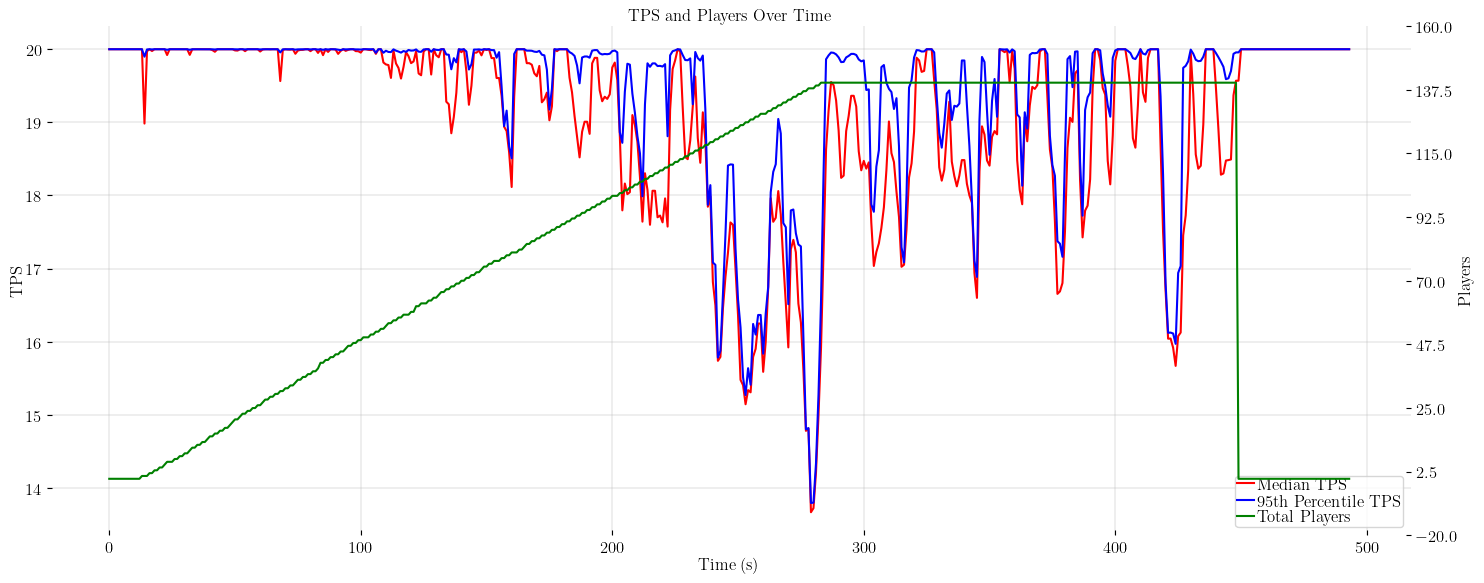

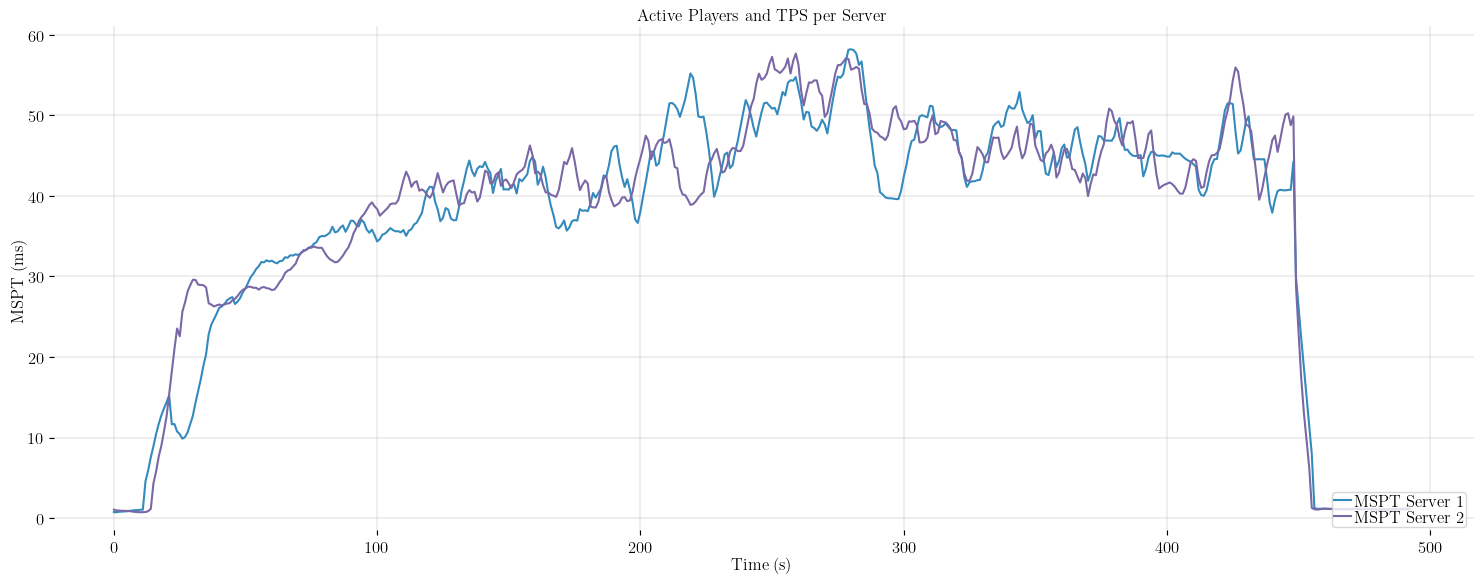

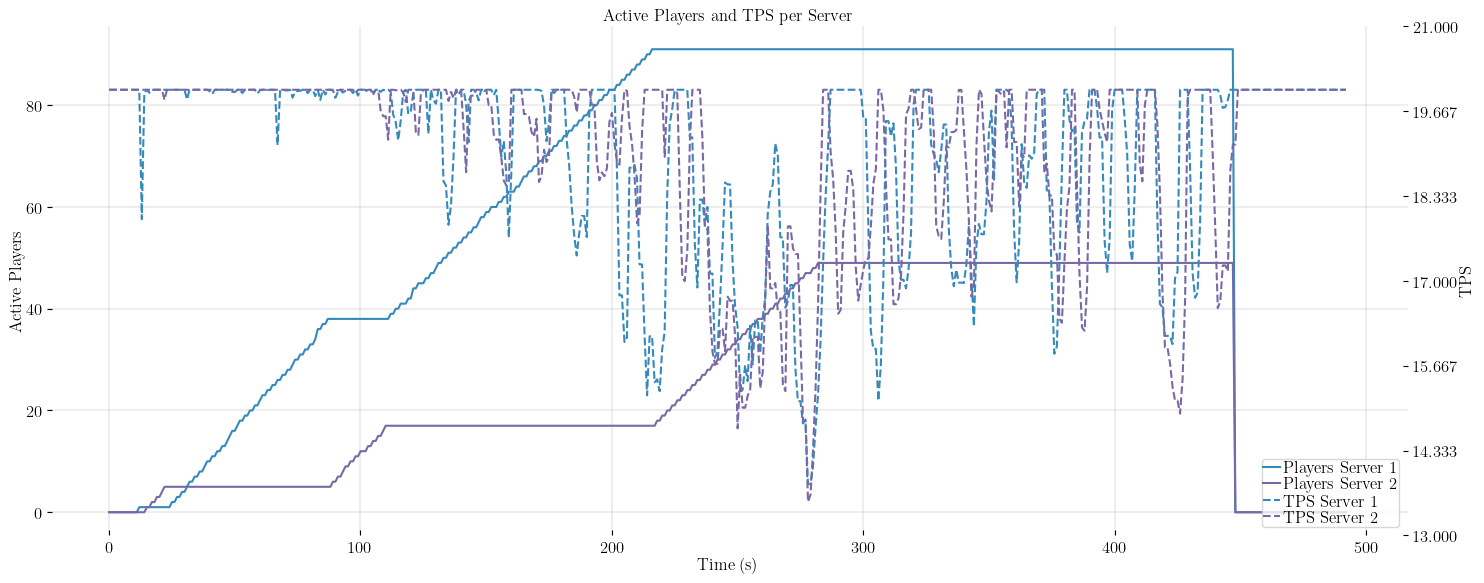

KeyError: 'chunk_owner'

In [57]:
experiment = "2s_idle_interval"
tps_players_plot(experiment)
mspt_plot(experiment)
player_tps_server_plot(experiment)
chunk_ownership_plot(experiment)

# 8 Servers Idle Interval